# Installing the required libraries and modules 

In [1]:
 pip install lxml bs4 html5lib

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda update -n base -c defaults conda

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you need to install folium
import folium # map rendering library

from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe



# Scraping and Cleaning the Data

In [4]:
to_hoods = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969')[0]

In [5]:
to_hoods = to_hoods[to_hoods['Borough']!='Not assigned']

In [6]:
to_hoods['Neighbourhood']=np.where(to_hoods['Neighbourhood']=='Not assigned',to_hoods['Borough'],to_hoods['Neighbourhood']) #using np.where(condition,y,n) to replace any 'Not assigned' values in the Neighbourhood column with the values in the Borough column

In [7]:
to_hoods = to_hoods.rename(columns={'Neighbourhood' : 'Neighborhood'}) #converting the canadian spelling to american to avoid conflicts

In [8]:
to_hoods.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [9]:
to_hoods.shape

(103, 3)

In [10]:
to_hoods = to_hoods.groupby(['Postal Code'], sort=False).agg(', '.join)


In [11]:
to_hoods.reset_index(drop= False)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [12]:
to_hoods

,Borough,Neighborhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...
M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
M4Y,Downtown Toronto,Church and Wellesley
M7Y,East Toronto,"Business reply mail Processing Centre, South C..."


# Gathering the coordiantes for each neighborhood

In [13]:
lat_lng_coords = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lng_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Dataframe including the Latitude and Longitude values

In [14]:
to_hoods_coords = pd.merge(to_hoods,lat_lng_coords,on='Postal Code')
to_hoods_coords

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


to_hoods_coords = to_hoods_coords[to_hoods_coords['Borough'].str.contains('Toronto',regex=False)]
to_hoods_coords

In [15]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [16]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(to_hoods_coords['Latitude'], to_hoods_coords['Longitude'], to_hoods_coords['Borough'], to_hoods_coords['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Setting up the API GET request

In [17]:
CLIENT_ID = 'PVM454TJSFO2OJDHJJCDXHNPFFVD30T4FZFBRBO5YKAQ1E4G' # your Foursquare ID
CLIENT_SECRET = '3EA21F25FU2XBVCUVJSDUCFI1IQEUKRWUZ2IPA240DGSNDOF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Toronto has sprawling neighborhoods therefore the radius is set to 1000m

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius= 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Printing out the results

In [19]:
toronto_venues = getNearbyVenues(names=to_hoods_coords['Neighborhood'],
                                   latitudes=to_hoods_coords['Latitude'],
                                   longitudes=to_hoods_coords['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [20]:
print(toronto_venues.shape)
toronto_venues.head()

(4882, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
4,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store


## Counting the number of venues per neighborhood

In [21]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,50,50,50,50,50,50
"Alderwood, Long Branch",28,28,28,28,28,28
"Bathurst Manor, Wilson Heights, Downsview North",32,32,32,32,32,32
Bayview Village,15,15,15,15,15,15
"Bedford Park, Lawrence Manor East",41,41,41,41,41,41
...,...,...,...,...,...,...
"Willowdale, Willowdale West",11,11,11,11,11,11
Woburn,9,9,9,9,9,9
Woodbine Heights,27,27,27,27,27,27


In [22]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 331 uniques categories.


## Preparing the data for clustering by running one hot encoding

In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
toronto_onehot.shape

(4882, 331)

In [25]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02439,0.0,...,0.0,0.02439,0.0,0.0,0.0,0.0,0.0,0.02439,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
94,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
95,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
96,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [26]:
toronto_grouped.shape

(98, 331)

## Finding the Top 5 venue types in each neighborhood

In [27]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.12
1         Shopping Mall  0.08
2  Caribbean Restaurant  0.04
3                Bakery  0.04
4           Pizza Place  0.04


----Alderwood, Long Branch----
               venue  freq
0     Discount Store  0.11
1        Pizza Place  0.07
2               Park  0.07
3  Convenience Store  0.07
4        Gas Station  0.04


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0         Park  0.06
1         Bank  0.06
2  Pizza Place  0.06
3  Coffee Shop  0.06
4  Gas Station  0.03


----Bayview Village----
                 venue  freq
0                 Bank  0.13
1        Grocery Store  0.13
2          Gas Station  0.13
3  Japanese Restaurant  0.13
4           Restaurant  0.07


----Bedford Park, Lawrence Manor East----
                  venue  freq
0    Italian Restaurant  0.07
1           Coffee Shop  0.07
2  Fast Food Restaurant  0.05
3             Pet Store  0.05
4        Sandwich Place  0.05

----Leaside----
                    venue  freq
0     Sporting Goods Shop  0.07
1             Coffee Shop  0.07
2           Grocery Store  0.05
3       Electronics Store  0.05
4  Furniture / Home Store  0.05


----Little Portugal, Trinity----
                venue  freq
0                Café  0.08
1                 Bar  0.07
2          Restaurant  0.06
3              Bakery  0.04
4  Italian Restaurant  0.04


----Malvern, Rouge----
                  venue  freq
0  Fast Food Restaurant  0.11
1           Coffee Shop  0.11
2                 Trail  0.11
3                   Spa  0.05
4           Supermarket  0.05


----Milliken, Agincourt North, Steeles East, L'Amoreaux East----
                venue  freq
0  Chinese Restaurant  0.19
1                Park  0.07
2        Intersection  0.07
3         Pizza Place  0.07
4        Noodle House  0.07


----Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West----
                  venue  freq
0            R

                 venue  freq
0                 Park  0.13
1        Train Station  0.13
2       Sandwich Place  0.07
3           Restaurant  0.07
4  Fried Chicken Joint  0.07


----Wexford, Maryvale----
                       venue  freq
0                Pizza Place  0.11
1  Middle Eastern Restaurant  0.11
2              Grocery Store  0.07
3               Burger Joint  0.07
4          Indian Restaurant  0.04


----Willowdale, Newtonbrook----
                       venue  freq
0          Korean Restaurant  0.14
1                       Café  0.11
2  Middle Eastern Restaurant  0.07
3                Pizza Place  0.07
4                       Park  0.07


----Willowdale, Willowdale East----
                 venue  freq
0          Coffee Shop  0.07
1    Korean Restaurant  0.06
2      Bubble Tea Shop  0.06
3     Ramen Restaurant  0.06
4  Japanese Restaurant  0.05


----Willowdale, Willowdale West----
               venue  freq
0           Pharmacy  0.18
1  Convenience Store  0.09
2        Pizz

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Generating a dataframe that contains the top 10 most common venues per neighborhood
### These will be used as features for the KMean analysis

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Caribbean Restaurant,Bakery,Pizza Place,Sandwich Place,Restaurant,Mediterranean Restaurant,Sushi Restaurant,Supermarket
1,"Alderwood, Long Branch",Discount Store,Pizza Place,Park,Convenience Store,Gas Station,Bagel Shop,Grocery Store,Liquor Store,Sandwich Place,Print Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Bank,Pizza Place,Coffee Shop,Gas Station,Sandwich Place,Sushi Restaurant,Mediterranean Restaurant,Supermarket,Men's Store
3,Bayview Village,Bank,Grocery Store,Gas Station,Japanese Restaurant,Restaurant,Chinese Restaurant,Park,Shopping Mall,Trail,Café
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Fast Food Restaurant,Pet Store,Sandwich Place,Bank,Restaurant,Cosmetics Shop,Sushi Restaurant,Bridal Shop


In [30]:
neighborhoods_venues_sorted.shape

(98, 11)

## Before we run the kMeans algorith we need to find the optimal K value using the Elbow Method

In [31]:
distortions = []
K = range(1,9)
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    distortions.append(kmeans.inertia_)

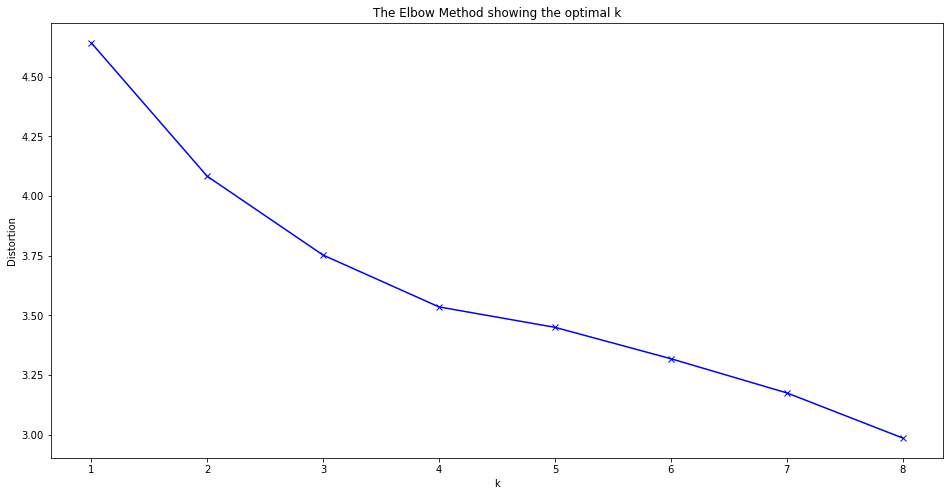

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### While there is no clear elbow the best value for K is 4 clusters

## Now we run the KMean analysis using k=4

In [33]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 0, 0, 1, 0, 0, 0], dtype=int32)

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = to_hoods_coords

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3.0,Park,Pharmacy,Bus Stop,Shopping Mall,Supermarket,Coffee Shop,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Cosmetics Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,3.0,Coffee Shop,Hockey Arena,Grocery Store,Lounge,Gym / Fitness Center,Men's Store,French Restaurant,Golf Course,Pizza Place,Playground
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Café,Theater,Park,Restaurant,Breakfast Spot,Bakery,Pub,Diner,Sushi Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Fast Food Restaurant,Coffee Shop,Furniture / Home Store,Restaurant,Vietnamese Restaurant,Arts & Crafts Store,Sushi Restaurant,Dessert Shop,Fried Chicken Joint
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Park,Thai Restaurant,Ramen Restaurant,Café,Italian Restaurant,Hotel,Burger Joint


## Removing neighborhoods that do not contain any venues

In [35]:
toronto_merged[toronto_merged['Cluster Labels'].isna()]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
toronto_merged.dropna(subset = ["Cluster Labels"], inplace=True)

## Visualising the result

In [37]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['blue', 'orange', 'red', 'yellow', 'black', 'cadetblue']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [38]:
map_clusters.save("map_clusters.html")

# Cluster 1: Urban (Downtown + Airport + Univerities + Subway Line):

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park, Harbourfront",0.0,Coffee Shop,Café,Theater,Park,Restaurant,Breakfast Spot,Bakery,Pub,Diner,Sushi Restaurant
3,"Lawrence Manor, Lawrence Heights",0.0,Clothing Store,Fast Food Restaurant,Coffee Shop,Furniture / Home Store,Restaurant,Vietnamese Restaurant,Arts & Crafts Store,Sushi Restaurant,Dessert Shop,Fried Chicken Joint
4,"Queen's Park, Ontario Provincial Government",0.0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Park,Thai Restaurant,Ramen Restaurant,Café,Italian Restaurant,Hotel,Burger Joint
6,"Malvern, Rouge",0.0,Fast Food Restaurant,Coffee Shop,Trail,Spa,Supermarket,Bank,Bakery,Caribbean Restaurant,Gym,Paper / Office Supplies Store
7,Don Mills,0.0,Restaurant,Coffee Shop,Gym,Japanese Restaurant,Café,Pizza Place,Supermarket,Burger Joint,Athletics & Sports,Asian Restaurant
8,"Parkview Hill, Woodbine Gardens",0.0,Gym / Fitness Center,Coffee Shop,Brewery,Pizza Place,Café,Athletics & Sports,Pet Store,Pharmacy,Rock Climbing Spot,Flea Market
9,"Garden District, Ryerson",0.0,Coffee Shop,Gastropub,Japanese Restaurant,Italian Restaurant,Theater,Cosmetics Shop,Restaurant,Café,Middle Eastern Restaurant,Clothing Store
13,Don Mills,0.0,Restaurant,Coffee Shop,Gym,Japanese Restaurant,Café,Pizza Place,Supermarket,Burger Joint,Athletics & Sports,Asian Restaurant
14,Woodbine Heights,0.0,Park,Coffee Shop,Café,Pizza Place,Sandwich Place,Convenience Store,Athletics & Sports,Curling Ice,Skating Rink,Beer Store
15,St. James Town,0.0,Coffee Shop,Café,Restaurant,Italian Restaurant,Seafood Restaurant,Cosmetics Shop,Bakery,Gastropub,Park,Clothing Store


# Cluster 2: Park Areas + Waterfront

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"West Deane Park, Princess Gardens, Martin Grov...",1.0,Park,Pizza Place,Hotel,Bank,Gym,Grocery Store,Mexican Restaurant,Fish & Chips Shop,Restaurant,Clothing Store
12,"Rouge Hill, Port Union, Highland Creek",1.0,Breakfast Spot,Park,Playground,Burger Joint,Italian Restaurant,New American Restaurant,Other Great Outdoors,Organic Grocery,Optical Shop,Office
51,"Cliffside, Cliffcrest, Scarborough Village West",1.0,Pizza Place,Ice Cream Shop,Beach,Sports Bar,Park,Auto Garage,Restaurant,Zoo,New American Restaurant,Organic Grocery
58,"Birch Cliff, Cliffside West",1.0,Park,Convenience Store,Café,Ice Cream Shop,Thai Restaurant,Gym,General Entertainment,Gym Pool,College Stadium,Restaurant
64,Weston,1.0,Park,Train Station,Sandwich Place,Restaurant,Fried Chicken Joint,Soccer Field,Skating Rink,Coffee Shop,Pharmacy,Jewelry Store
66,York Mills West,1.0,Park,Restaurant,Coffee Shop,Convenience Store,French Restaurant,Business Service,Gas Station,Tennis Court,Grocery Store,Dog Run
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",1.0,Park,Ice Cream Shop,Gym / Fitness Center,Shopping Mall,Italian Restaurant,Eastern European Restaurant,Bus Stop,Office,Outdoors & Recreation,Other Repair Shop


# Cluster 3: Outlier (Suburban neighborhood near highway junction)

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"York Mills, Silver Hills",2.0,Park,Pool,Zoo,Music Venue,Organic Grocery,Optical Shop,Office,Noodle House,Nightclub,New American Restaurant


# Cluster 4: Suburbs

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,3.0,Park,Pharmacy,Bus Stop,Shopping Mall,Supermarket,Coffee Shop,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Cosmetics Shop
1,Victoria Village,3.0,Coffee Shop,Hockey Arena,Grocery Store,Lounge,Gym / Fitness Center,Men's Store,French Restaurant,Golf Course,Pizza Place,Playground
5,"Islington Avenue, Humber Valley Village",3.0,Pharmacy,Convenience Store,Café,Skating Rink,Shopping Mall,Golf Course,Bank,Bakery,Park,Grocery Store
10,Glencairn,3.0,Grocery Store,Fast Food Restaurant,Gas Station,Park,Pizza Place,Coffee Shop,Ice Cream Shop,Asian Restaurant,Metro Station,Mediterranean Restaurant
16,Humewood-Cedarvale,3.0,Convenience Store,Pizza Place,Coffee Shop,Grocery Store,Restaurant,Dance Studio,Food & Drink Shop,Optical Shop,Middle Eastern Restaurant,Mexican Restaurant
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",3.0,Coffee Shop,Pharmacy,Beer Store,Farmers Market,Grocery Store,Shopping Mall,Café,Park,Skating Rink,Gas Station
18,"Guildwood, Morningside, West Hill",3.0,Pizza Place,Coffee Shop,Fast Food Restaurant,Bank,Sports Bar,Food & Drink Shop,Fried Chicken Joint,Smoothie Shop,Supermarket,Beer Store
21,Caledonia-Fairbanks,3.0,Pharmacy,Pizza Place,Park,Cosmetics Shop,Sporting Goods Shop,Bus Stop,Mexican Restaurant,Fast Food Restaurant,Falafel Restaurant,Bank
22,Woburn,3.0,Coffee Shop,Park,Fast Food Restaurant,Mobile Phone Shop,Indian Restaurant,Chinese Restaurant,Pharmacy,Other Repair Shop,Other Great Outdoors,Organic Grocery
26,Cedarbrae,3.0,Indian Restaurant,Gas Station,Bank,Coffee Shop,Bakery,Fried Chicken Joint,Music Store,Fast Food Restaurant,Pharmacy,Pizza Place
